In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os 

import missingno as msno

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
from collections import Counter

In [2]:
import random

seed = 42
random.seed(seed)
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

In [3]:
test_df = pd.read_csv('/kaggle/input/2024-smarcle-ks-2house-price/test.csv')
train_df = pd.read_csv('/kaggle/input/2024-smarcle-ks-2house-price/train.csv')
submit = pd.read_csv('/kaggle/input/2024-smarcle-ks-2house-price/sample_submission.csv')

In [4]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
print(train_df.shape)
print(test_df.shape)

(1460, 81)
(1459, 80)


In [7]:
numerical = train_df.select_dtypes(exclude=['object']).columns
categorical = train_df.select_dtypes(include=['object']).columns

print("Num of numerical feats: ", len(numerical))
print("Num of categorical feats: ", len(categorical))

Num of numerical feats:  38
Num of categorical feats:  43


In [8]:
print(train_df[numerical].columns)
print("="*90)
print(train_df[categorical].columns)

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', '

In [9]:
def detect_outliers(df, n, features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
        
    return multiple_outliers
        
Outliers_to_drop = detect_outliers(train_df, 2, ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold'])

In [10]:
train_df = train_df.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [11]:
for col in test_df.columns:
    msperc = 'column: {:>10}\t Null: {:.2f}%'.format(col, 100 * (test_df[col].isnull().sum() / test_df[col].shape[0]))
    print(msperc)

column:         Id	 Null: 0.00%
column: MSSubClass	 Null: 0.00%
column:   MSZoning	 Null: 0.27%
column: LotFrontage	 Null: 15.56%
column:    LotArea	 Null: 0.00%
column:     Street	 Null: 0.00%
column:      Alley	 Null: 92.67%
column:   LotShape	 Null: 0.00%
column: LandContour	 Null: 0.00%
column:  Utilities	 Null: 0.14%
column:  LotConfig	 Null: 0.00%
column:  LandSlope	 Null: 0.00%
column: Neighborhood	 Null: 0.00%
column: Condition1	 Null: 0.00%
column: Condition2	 Null: 0.00%
column:   BldgType	 Null: 0.00%
column: HouseStyle	 Null: 0.00%
column: OverallQual	 Null: 0.00%
column: OverallCond	 Null: 0.00%
column:  YearBuilt	 Null: 0.00%
column: YearRemodAdd	 Null: 0.00%
column:  RoofStyle	 Null: 0.00%
column:   RoofMatl	 Null: 0.00%
column: Exterior1st	 Null: 0.07%
column: Exterior2nd	 Null: 0.07%
column: MasVnrType	 Null: 61.27%
column: MasVnrArea	 Null: 1.03%
column:  ExterQual	 Null: 0.00%
column:  ExterCond	 Null: 0.00%
column: Foundation	 Null: 0.00%
column:   BsmtQual	 Null: 3

In [12]:
for col in train_df.columns:
    msperc = 'column: {:>10}\t Null: {:.2f}%'.format(col, 100 * (train_df[col].isnull().sum() / train_df[col].shape[0]))
    print(msperc)

column:         Id	 Null: 0.00%
column: MSSubClass	 Null: 0.00%
column:   MSZoning	 Null: 0.00%
column: LotFrontage	 Null: 17.12%
column:    LotArea	 Null: 0.00%
column:     Street	 Null: 0.00%
column:      Alley	 Null: 94.10%
column:   LotShape	 Null: 0.00%
column: LandContour	 Null: 0.00%
column:  Utilities	 Null: 0.00%
column:  LotConfig	 Null: 0.00%
column:  LandSlope	 Null: 0.00%
column: Neighborhood	 Null: 0.00%
column: Condition1	 Null: 0.00%
column: Condition2	 Null: 0.00%
column:   BldgType	 Null: 0.00%
column: HouseStyle	 Null: 0.00%
column: OverallQual	 Null: 0.00%
column: OverallCond	 Null: 0.00%
column:  YearBuilt	 Null: 0.00%
column: YearRemodAdd	 Null: 0.00%
column:  RoofStyle	 Null: 0.00%
column:   RoofMatl	 Null: 0.00%
column: Exterior1st	 Null: 0.00%
column: Exterior2nd	 Null: 0.00%
column: MasVnrType	 Null: 59.27%
column: MasVnrArea	 Null: 0.52%
column:  ExterQual	 Null: 0.00%
column:  ExterCond	 Null: 0.00%
column: Foundation	 Null: 0.00%
column:   BsmtQual	 Null: 2

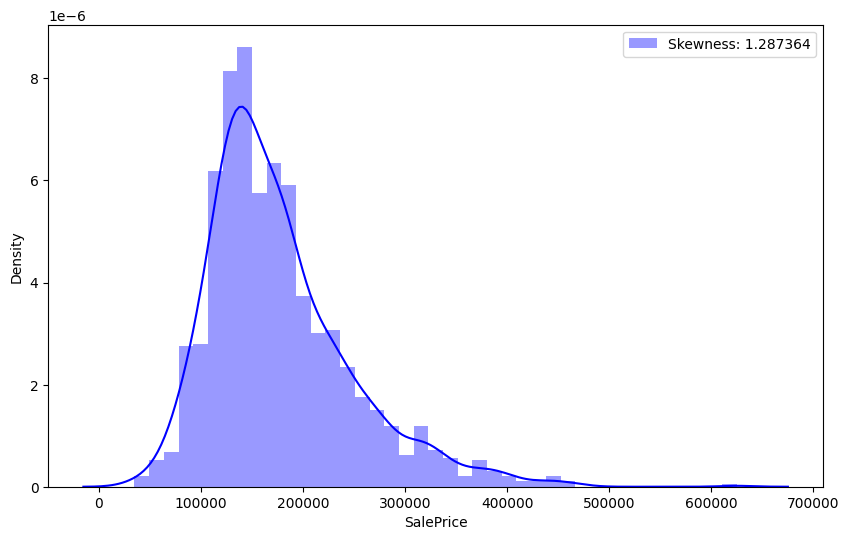

In [13]:
f, ax = plt.subplots(1, 1, figsize = (10,6))
g = sns.distplot(train_df["SalePrice"], color = "b", label="Skewness: {:2f}".format(train_df["SalePrice"].skew()), ax=ax)
g = g.legend(loc = "best")

In [14]:
from scipy import stats

shap_t,shap_p = stats.shapiro(train_df['SalePrice'])

print("Skewness: %f" % abs(train_df['SalePrice']).skew())
print("Kurtosis: %f" % abs(train_df['SalePrice']).kurt())
print("Shapiro_Test: %f" % shap_t)
print("Shapiro_Test: %f" % shap_p)

Skewness: 1.287364
Kurtosis: 2.555029
Shapiro_Test: 0.918256
Shapiro_Test: 0.000000


Skewness: -0.032026
Kurtosis: 0.571897


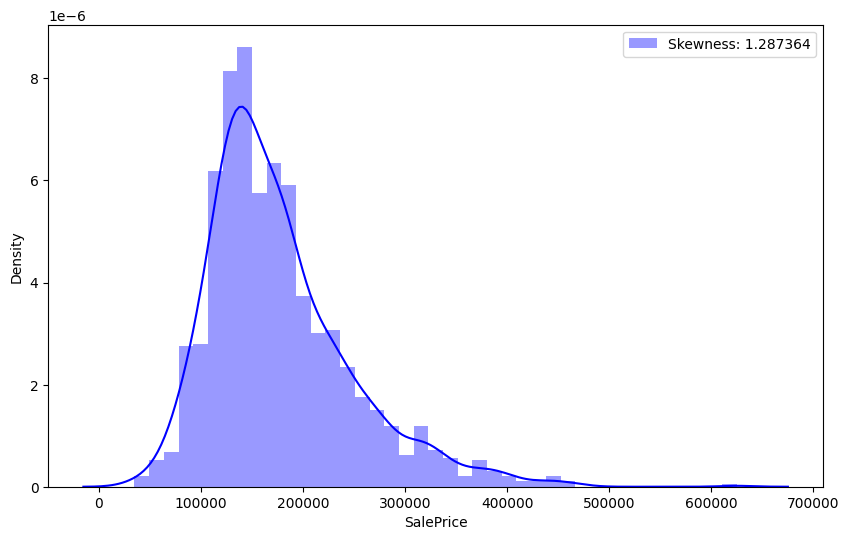

In [15]:
train_df["SalePrice_Log"] = train_df["SalePrice"].map(lambda i:np.log(i) if i>0 else 0)

f, ax = plt.subplots(1, 1, figsize = (10,6))
g = sns.distplot(train_df["SalePrice"], color = "b", label="Skewness: {:2f}".format(train_df["SalePrice"].skew()), ax=ax)
g = g.legend(loc = "best")

print("Skewness: %f" % train_df['SalePrice_Log'].skew())
print("Kurtosis: %f" % train_df['SalePrice_Log'].kurt())

In [16]:
train_df['SalePrice'].describe()

count      1338.000000
mean     176877.275037
std       70336.858965
min       34900.000000
25%      129900.000000
50%      161500.000000
75%      210000.000000
max      625000.000000
Name: SalePrice, dtype: float64

<Axes: xlabel='SalePrice', ylabel='Density'>

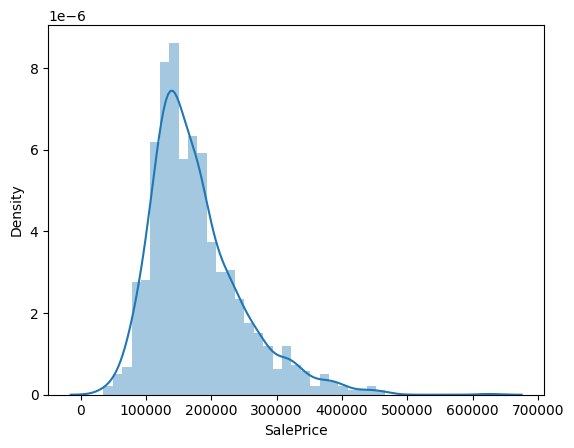

In [17]:
sns.distplot(train_df['SalePrice'])

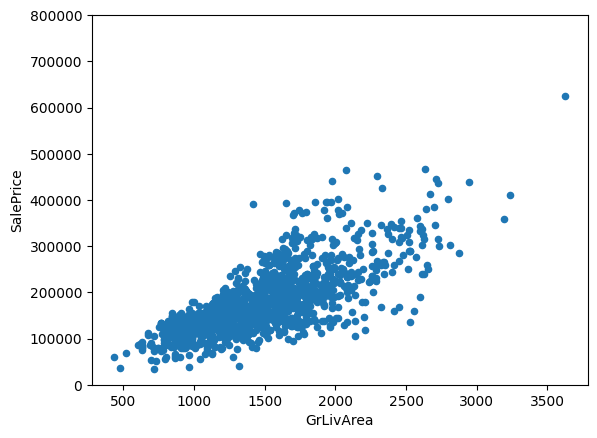

In [18]:
var = 'GrLivArea'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

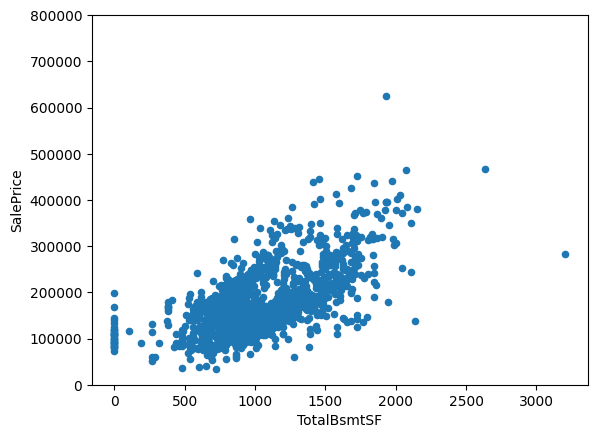

In [19]:
var = 'TotalBsmtSF'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

(-0.5, 9.5, 0.0, 800000.0)

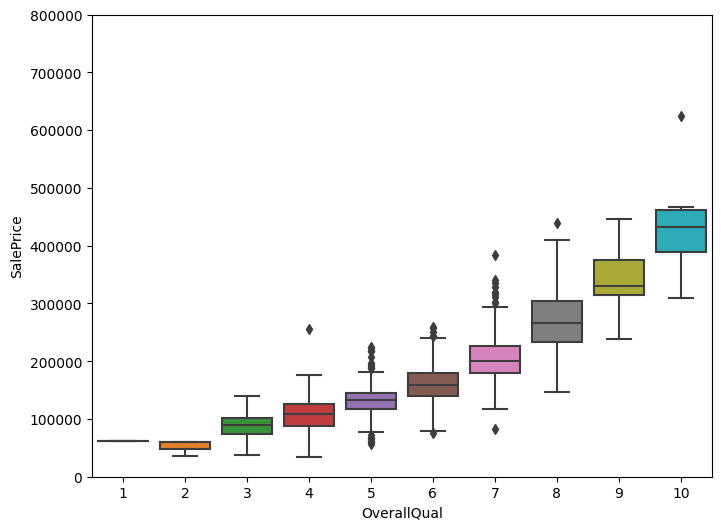

In [20]:
var='OverallQual'
data=pd.concat([train_df['SalePrice'],train_df[var]],axis=1)
f,ax=plt.subplots(figsize=(8,6))
fig=sns.boxplot(x=var,y="SalePrice",data=data)
fig.axis(ymin=0,ymax=800000)

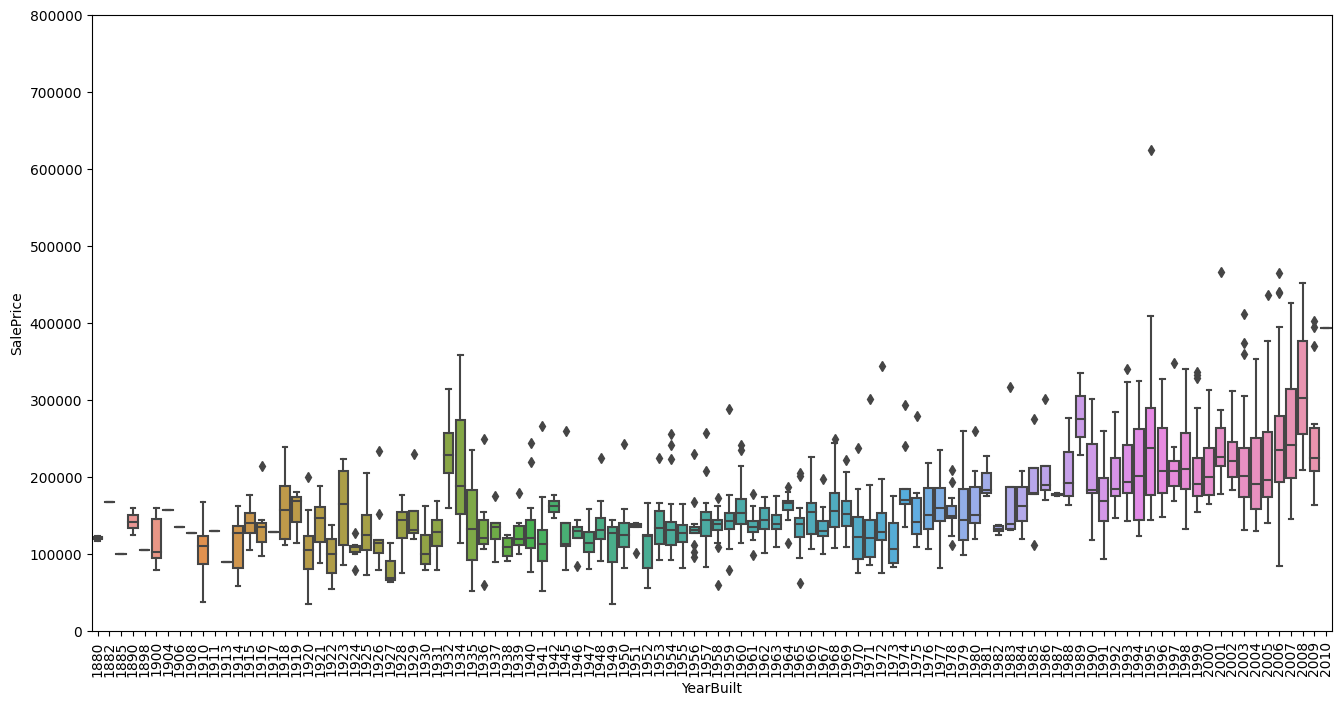

In [21]:
var = 'YearBuilt'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

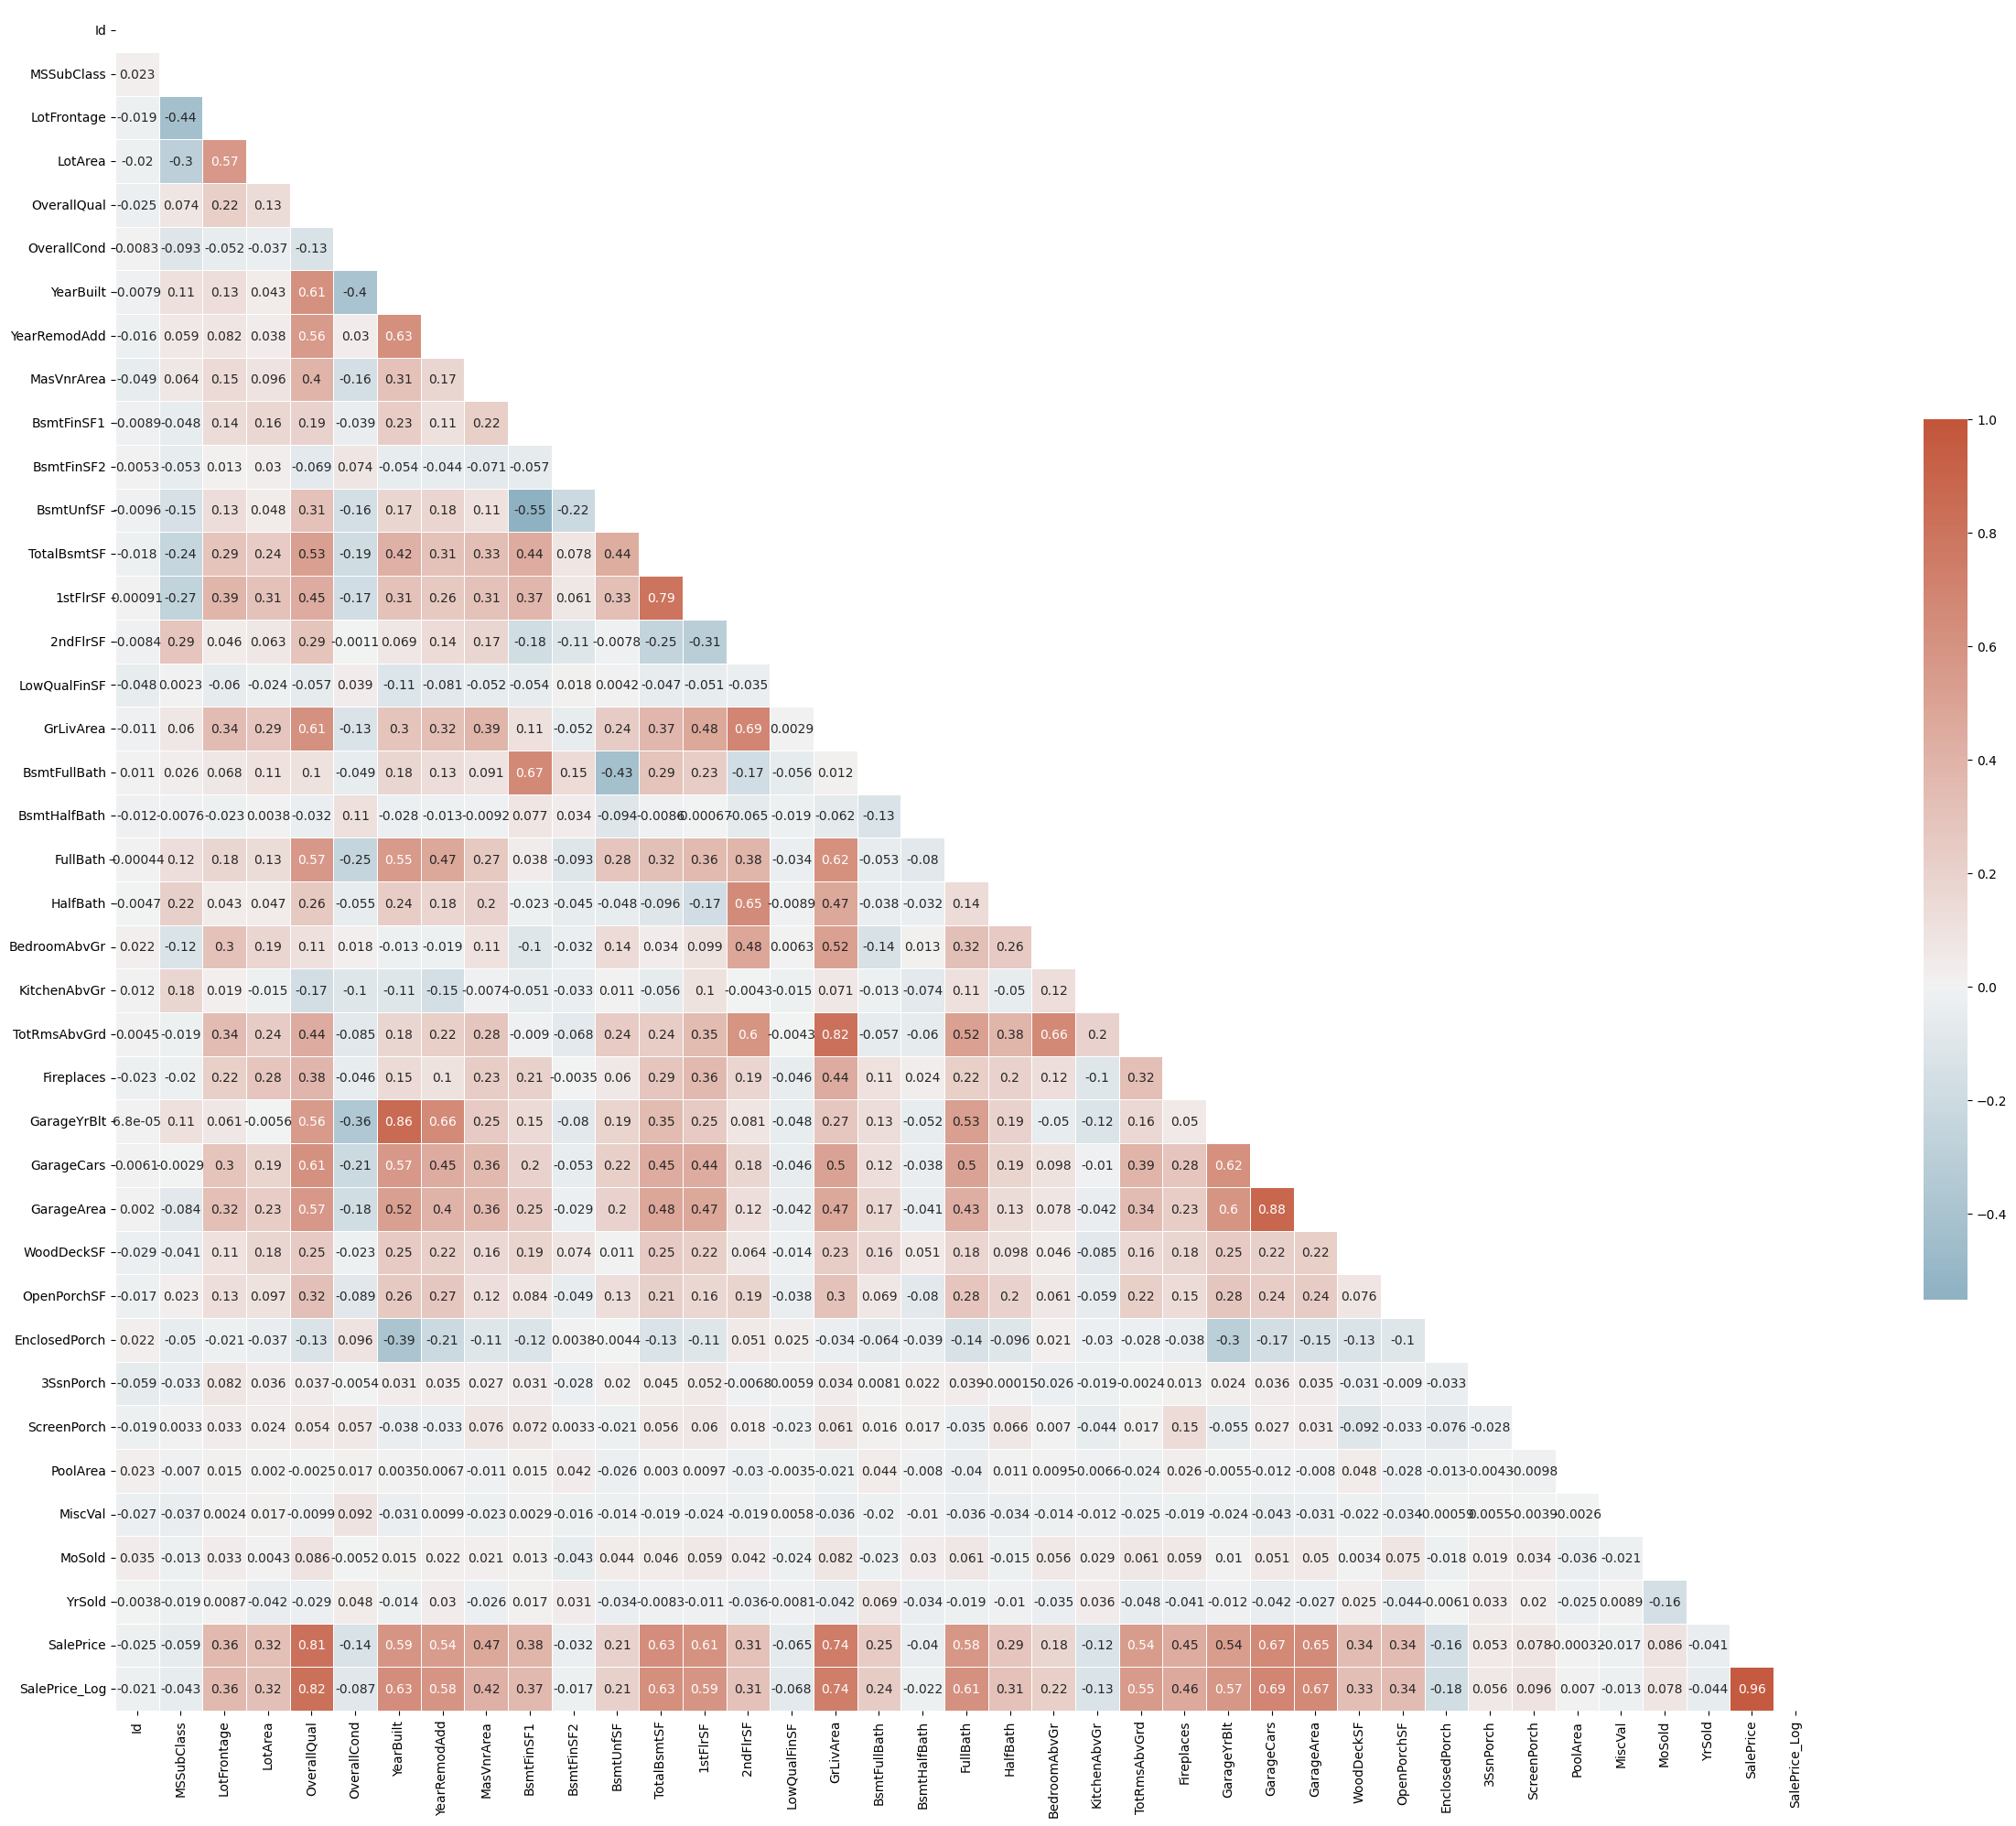

In [22]:
numeric_df = train_df.select_dtypes(include=[np.number])


f, ax = plt.subplots(figsize=(30, 25))
mat = numeric_df.corr('pearson')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

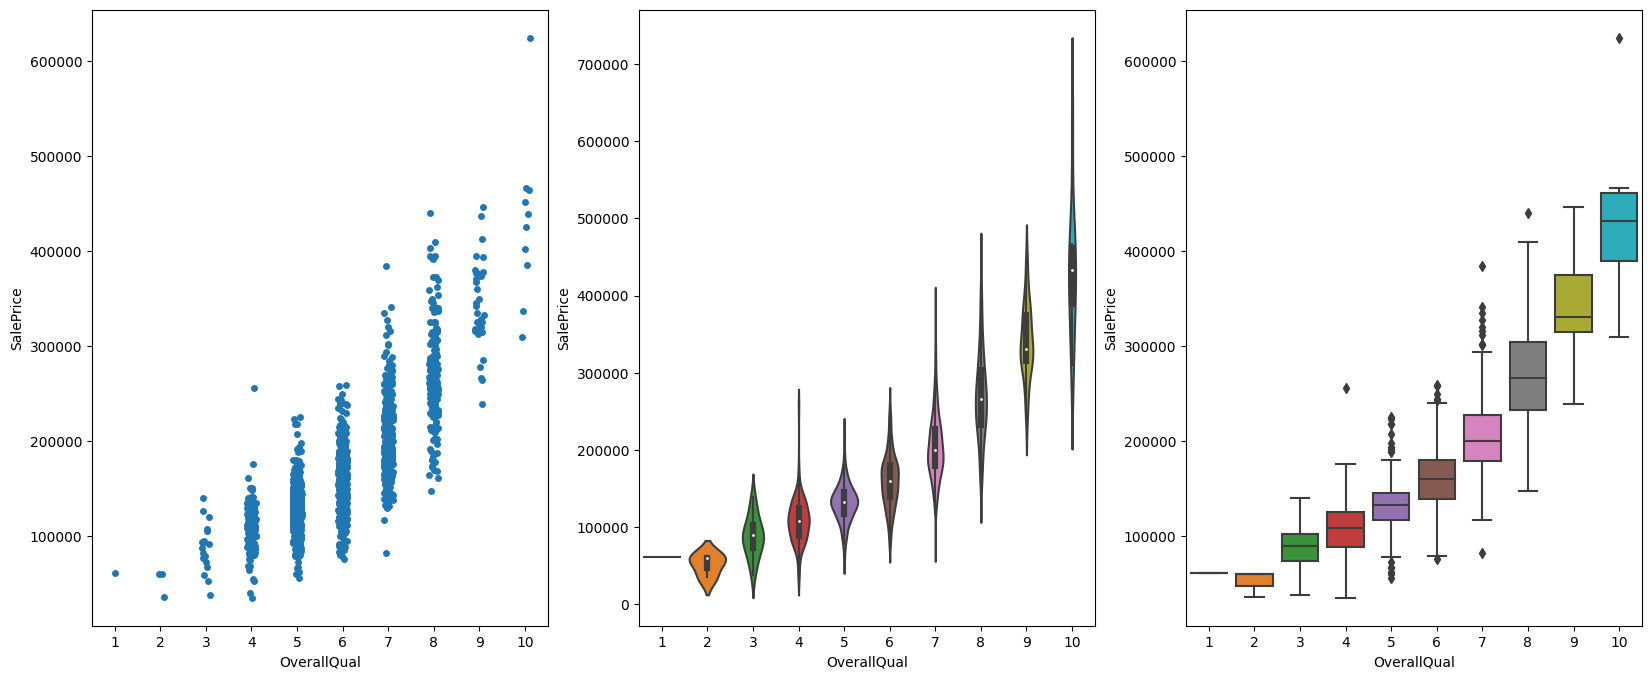

In [23]:
# OverallQuall - SalePrice [Pearson = 0.8]
figure, ax = plt.subplots(1,3, figsize = (20,8))
sns.stripplot(data=train_df, x = 'OverallQual', y='SalePrice', ax = ax[0])
sns.violinplot(data=train_df, x = 'OverallQual', y='SalePrice', ax = ax[1])
sns.boxplot(data=train_df, x = 'OverallQual', y='SalePrice', ax = ax[2])
plt.show()

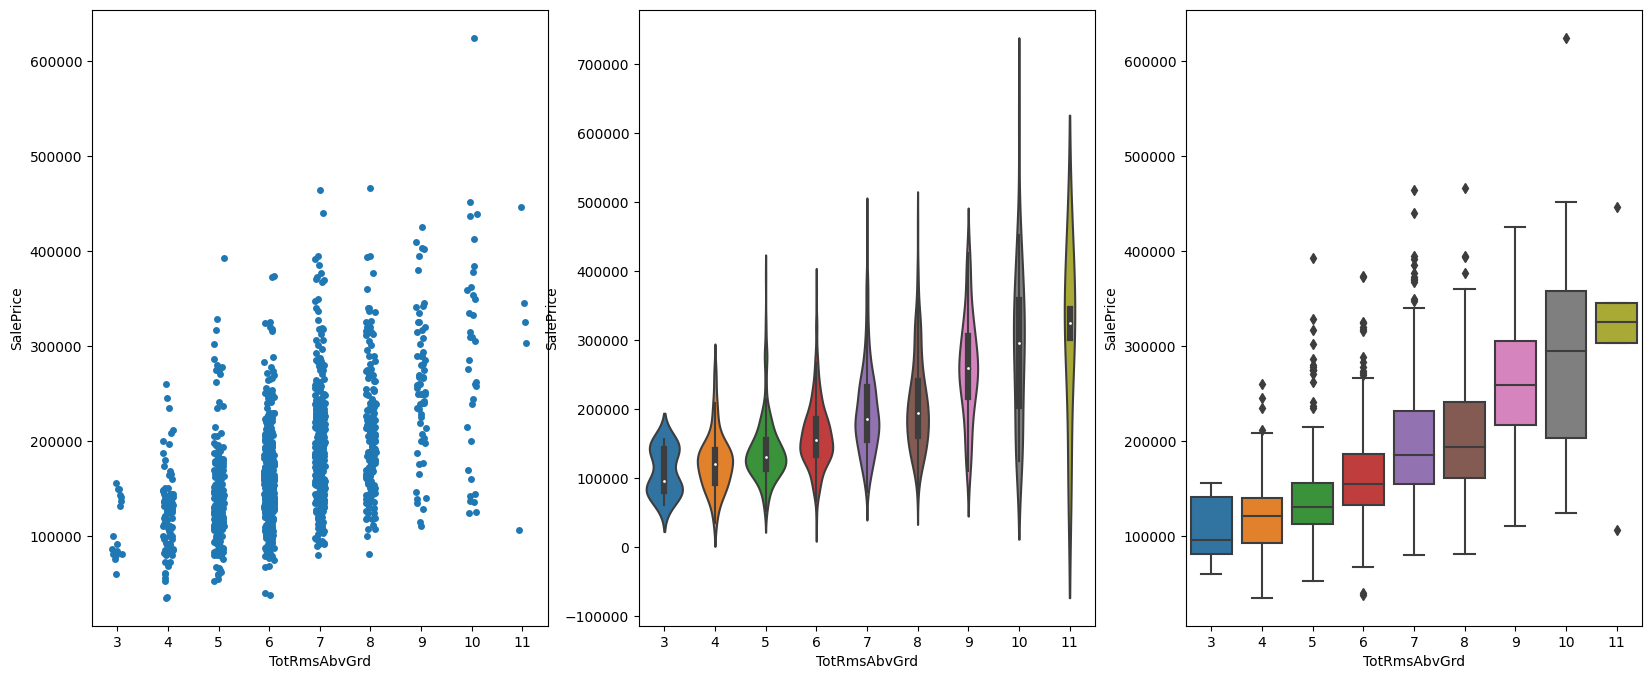

In [24]:
# TotRmsAbvGrd - SalePrice [Pearson = 0.50]

figure, ax = plt.subplots(1,3, figsize = (20,8))
sns.stripplot(data=train_df, x = 'TotRmsAbvGrd', y='SalePrice', ax = ax[0])
sns.violinplot(data=train_df, x = 'TotRmsAbvGrd', y='SalePrice', ax = ax[1])
sns.boxplot(data=train_df, x = 'TotRmsAbvGrd', y='SalePrice', ax = ax[2])
plt.show()

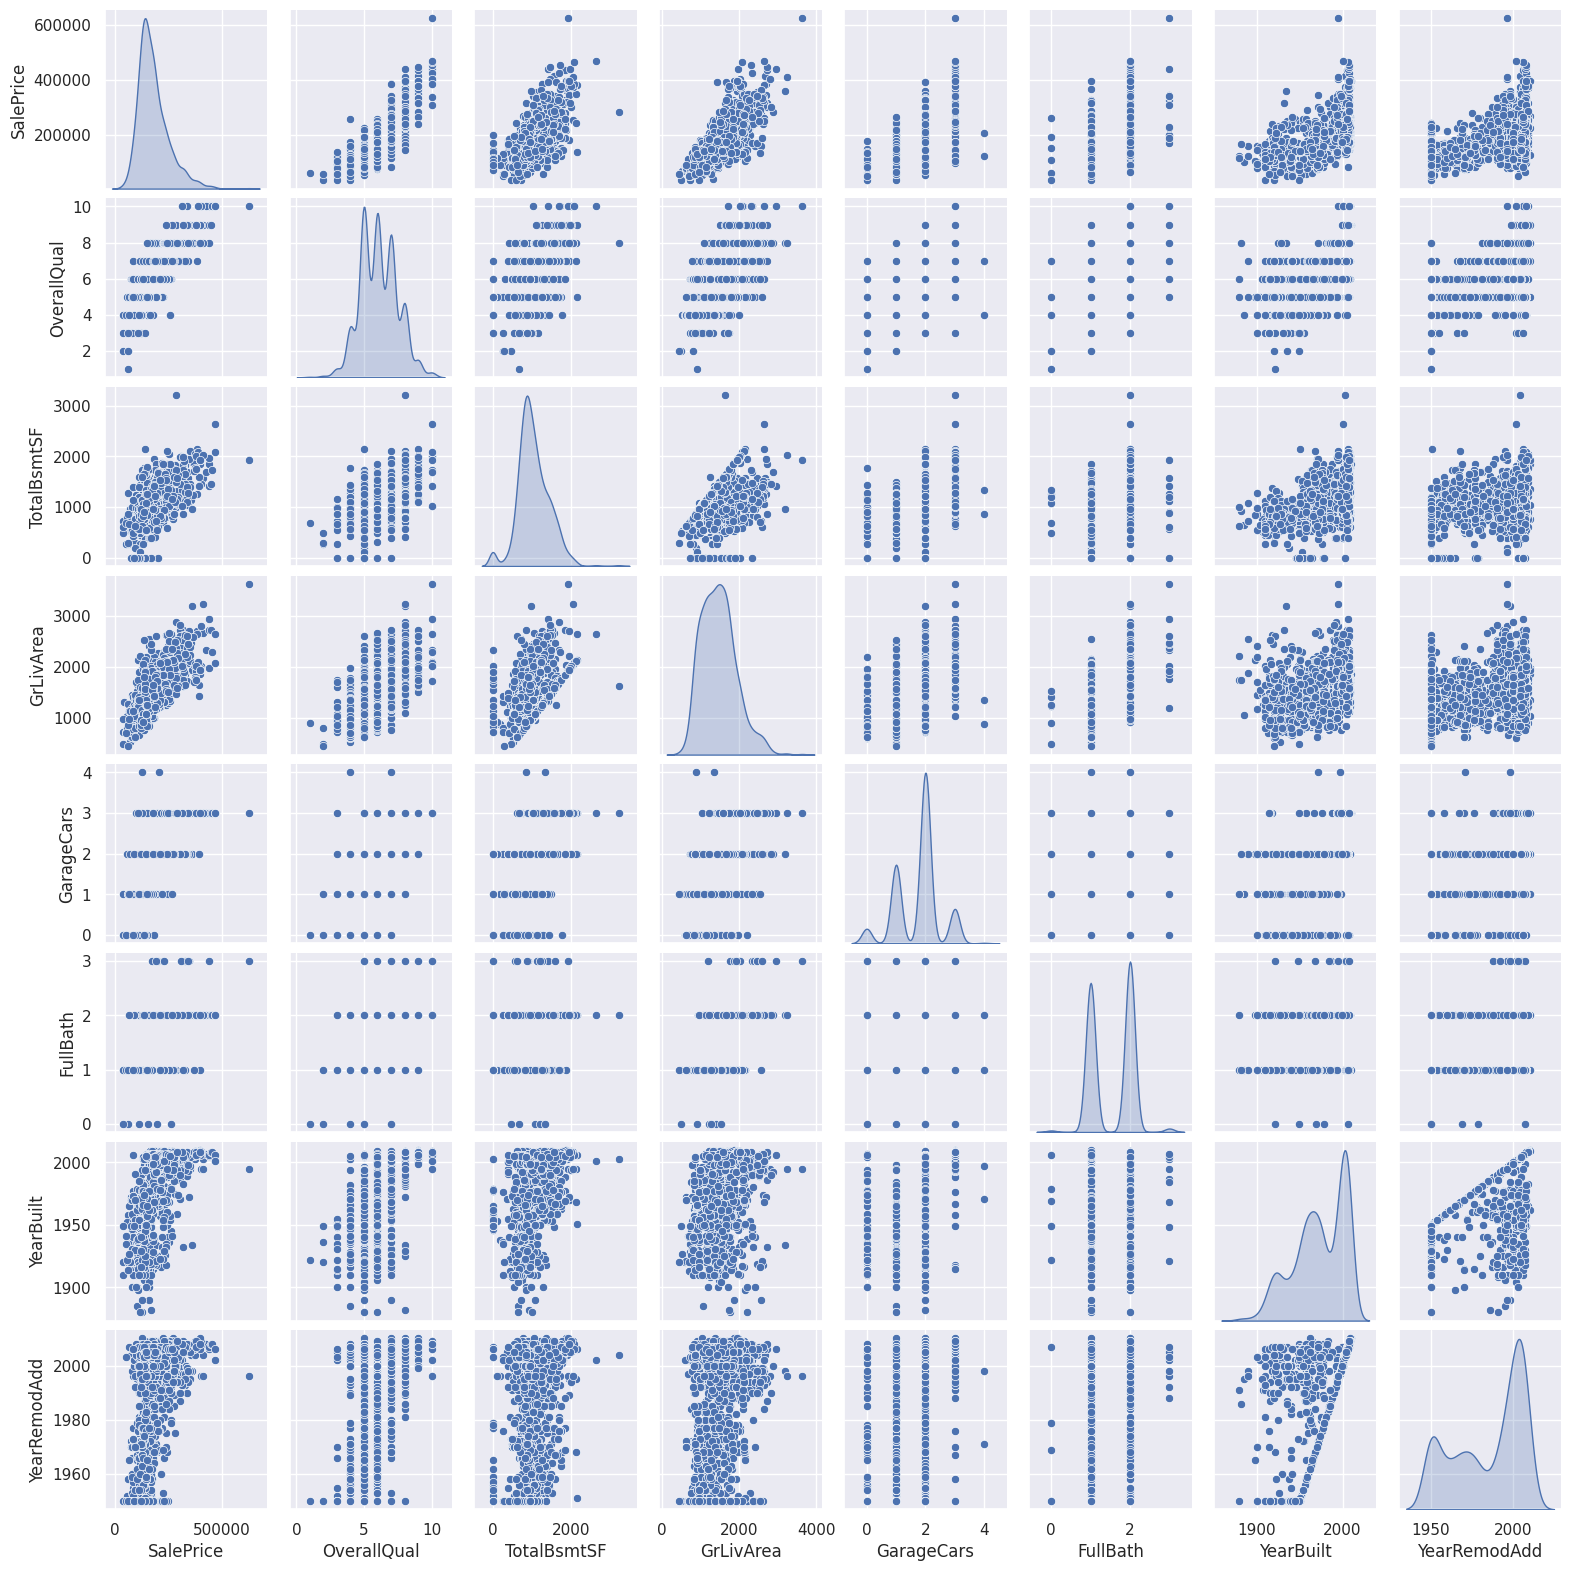

In [25]:
sns.set()
columns=['SalePrice','OverallQual','TotalBsmtSF','GrLivArea','GarageCars','FullBath','YearBuilt','YearRemodAdd']
sns.pairplot(train_df[columns],size=2,kind='scatter',diag_kind='kde')
plt.show()

In [26]:
for catg in list(categorical) :
    print(train_df[catg].value_counts())
    print('='*50)

MSZoning
RL         1055
RM          197
FV           65
RH           14
C (all)       7
Name: count, dtype: int64
Street
Pave    1335
Grvl       3
Name: count, dtype: int64
Alley
Grvl    42
Pave    37
Name: count, dtype: int64
LotShape
Reg    859
IR1    440
IR2     32
IR3      7
Name: count, dtype: int64
LandContour
Lvl    1211
Bnk      52
HLS      48
Low      27
Name: count, dtype: int64
Utilities
AllPub    1338
Name: count, dtype: int64
LotConfig
Inside     972
Corner     235
CulDSac     81
FR2         46
FR3          4
Name: count, dtype: int64
LandSlope
Gtl    1275
Mod      56
Sev       7
Name: count, dtype: int64
Neighborhood
NAmes      205
CollgCr    149
OldTown     93
Edwards     92
Somerst     85
Gilbert     79
NridgHt     71
Sawyer      68
NWAmes      66
BrkSide     56
SawyerW     54
Mitchel     46
Crawfor     44
NoRidge     37
IDOTRR      33
Timber      32
StoneBr     21
SWISU       20
ClearCr     19
Blmngtn     17
BrDale      16
MeadowV     15
Veenker     10
NPkVill      8


In [27]:
fillna_columns = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType', 'Electrical',
               'KitchenQual', 'SaleType', 'Functional', 'Exterior2nd', 'Exterior1st',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2',
               'MSZoning', 'Utilities']

for col in fillna_columns:
    train_df[col].fillna('None', inplace=True)
    test_df[col].fillna('None', inplace=True)

train_df.fillna(train_df.mean(numeric_only=True), inplace=True)
test_df.fillna(test_df.mean(numeric_only=True), inplace=True)

In [28]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
Id,0,0.0
GarageCars,0,0.0
GarageYrBlt,0,0.0
GarageType,0,0.0
FireplaceQu,0,0.0


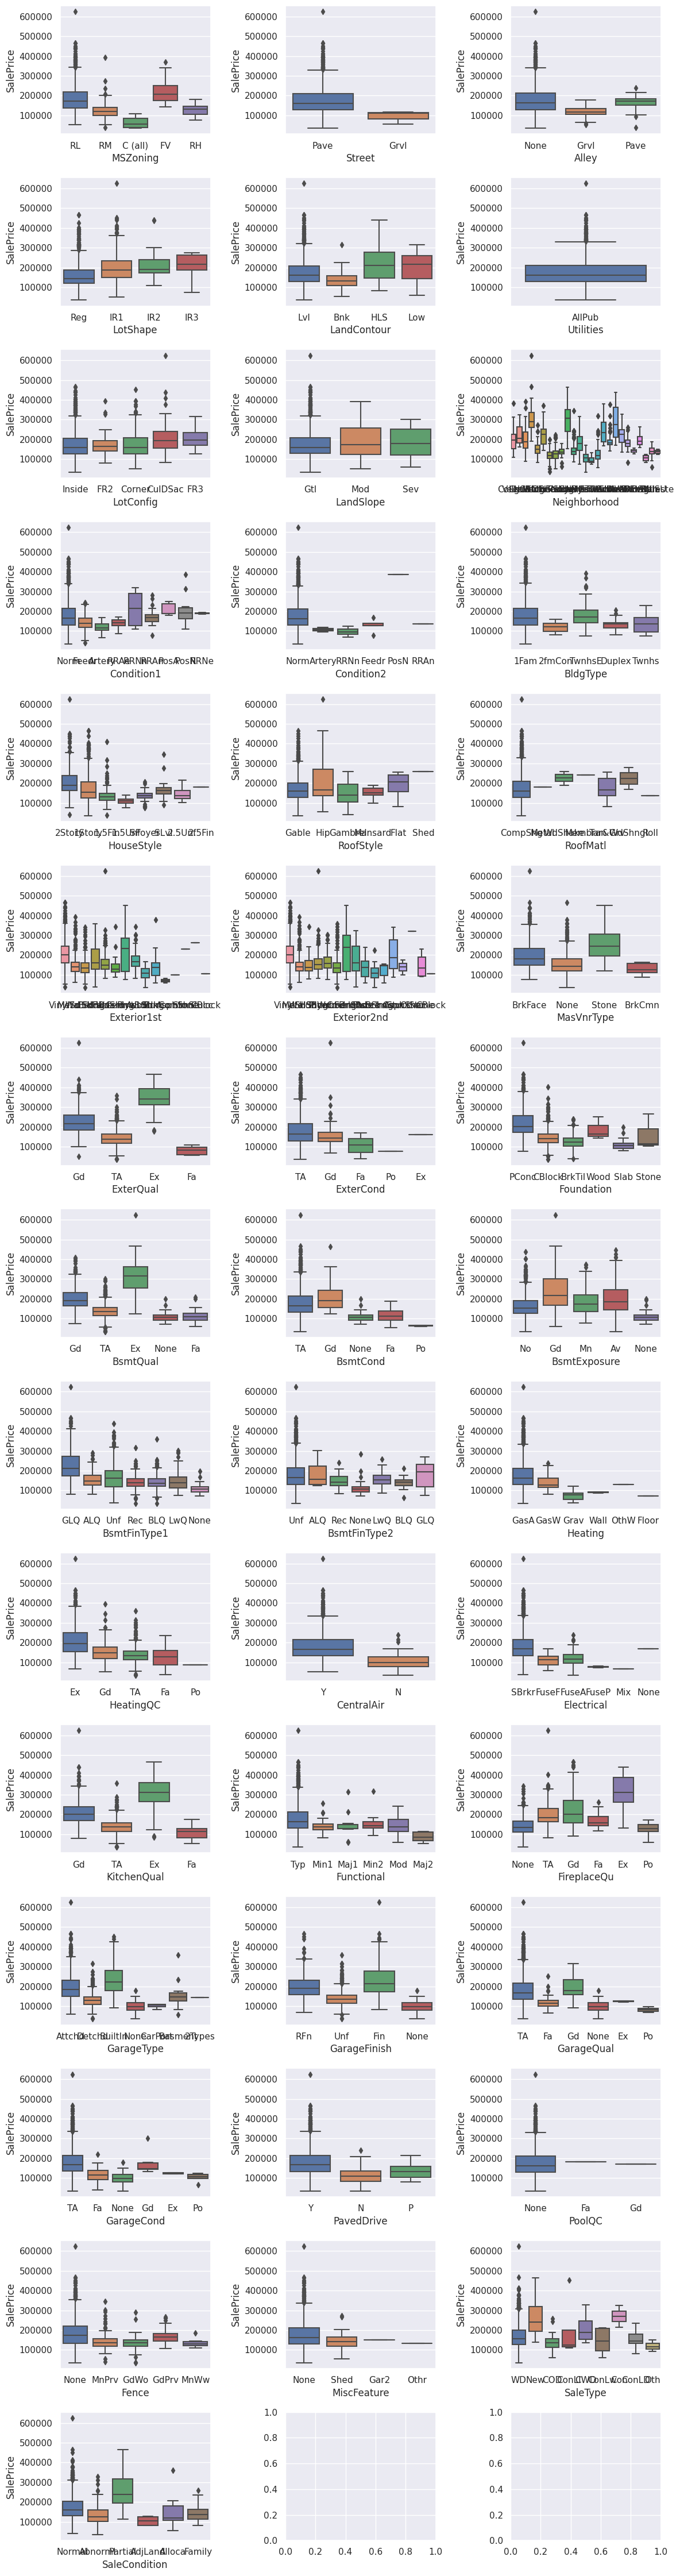

In [29]:
li_cat_feats = list(categorical)
nr_rows = 15
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_cat_feats):
            sns.boxplot(x=li_cat_feats[i], y=train_df["SalePrice"], data=train_df, ax = axs[r][c])
    
plt.tight_layout()    
plt.show()

In [30]:
numerical_strong = ['SalePrice','OverallQual','TotalBsmtSF','GrLivArea','GarageCars',
                   'FullBath','YearBuilt','YearRemodAdd']

numerical_weak = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1',
                 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF','LowQualFinSF', 'BsmtFullBath',
                 'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
                 'Fireplaces', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

catgorical_strong = ['MSZoning', 'Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual',
                    'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType']

catgorical_weak = ['Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 
                  'LandSlope', 'Condition1',  'BldgType', 'HouseStyle', 'RoofStyle', 
                  'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterCond', 'Foundation', 
                  'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 
                  'HeatingQC', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 
                  'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 
                  'SaleCondition' ]

In [31]:
train_df.drop('SalePrice', axis= 1, inplace=True)

**Credit**:

https://www.kaggle.com/code/kj0409/house-prices-kj